# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**Trend Elements**:

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.


**Seasonal Elements**:

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.


**SARIMA notation**: SARIMA(p,d,q)(P,D,Q,m)


Let's try to apply it to the Airline Passengers.

First, let's import all the library we need.

In [1]:
import warnings

from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.tsa.api as smt
import statsmodels.api as sm

We import the dataset:

In [2]:
# import data
data_set = pd.read_csv('data/airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

In [3]:
train = data_set[:'1957-01-01'].copy().rename(columns={"Thousands of Passengers": "train"})
test = data_set['1957-01-02':].copy().rename(columns={"Thousands of Passengers": "test"})

Prepare the evaluation functions:

In [4]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(y_true, y_pred):
    print("MAE:",mae(y_true, y_pred))
    print("MSE:", mse(y_true, y_pred))
    print("RMSE:", np.sqrt(mse(y_true, y_pred)))
    print("MAPE:", mape(y_true, y_pred))

In order to have baselines, let's pick up the results we obtained previously for the Persistent, the Holt and the Holt-Winters models:

In [5]:
test['Persistent'] = test['test'].shift(1)
evaluate(test['test'][1:], test['test'].shift(1)[1:])

MAE: 41.28260869565217
MSE: 2402.282608695652
RMSE: 49.01308609642584
MAPE: 9.87598070824141


In [6]:
warnings.filterwarnings("ignore") # suppress warnings

fitHolt = Holt(train['train']).fit(smoothing_level = 0.2,smoothing_trend = 0.05)
test['Holt'] = fitHolt.forecast(len(test))
evaluate(test['test'], test['Holt'])

MAE: 51.69007385588371
MSE: 4774.377208871444
RMSE: 69.09686830002822
MAPE: 11.635357567368738


In [7]:
warnings.filterwarnings("ignore") # suppress warnings

fitTES = ExponentialSmoothing(train['train'] ,seasonal_periods=12 ,trend='add', seasonal='add',use_boxcox=True,initialization_method="estimated").fit()
test['Holt-Winters'] = fitTES.forecast(len(test))
evaluate(test['test'], test['Holt-Winters'])

MAE: 37.72878685835209
MSE: 2004.9248687831064
RMSE: 44.77638740210186
MAPE: 9.27639976383433


## SARIMA

### Order selection

Let's plot the ACF and PACF in order to find the order for SARIMA:

In [8]:
# function for plotting acf and pacf plot to find the order of ARIMA models
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

To estimate the order of the ARIMA we first diff the data, and then plot tha ACF and PACF:

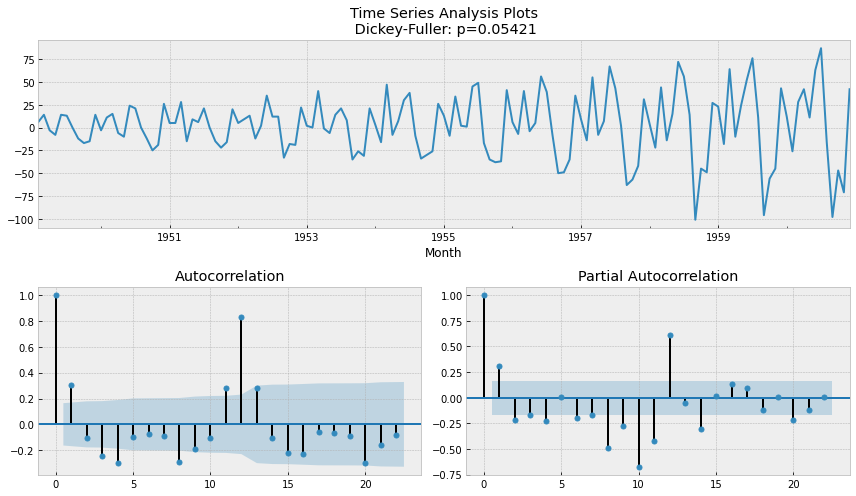

In [9]:
tsplot(data_set['Thousands of Passengers'].diff().dropna())

SARIMA MODEL ORDER **(p,d,q)x(P,D,Q,s)**

(p,d,q) part:

- p = Partial Autocorrelation plot = lag value at which the line touches the confidence interval first
- d = Differencing order
- q = Autocorrelation plot = lag value at which the line touches the confidence interval first

The order could be around:

- p = 1-2
- d = 1
- q = 0-1

Then we seasonal diff in order to focus on the seasonal part:

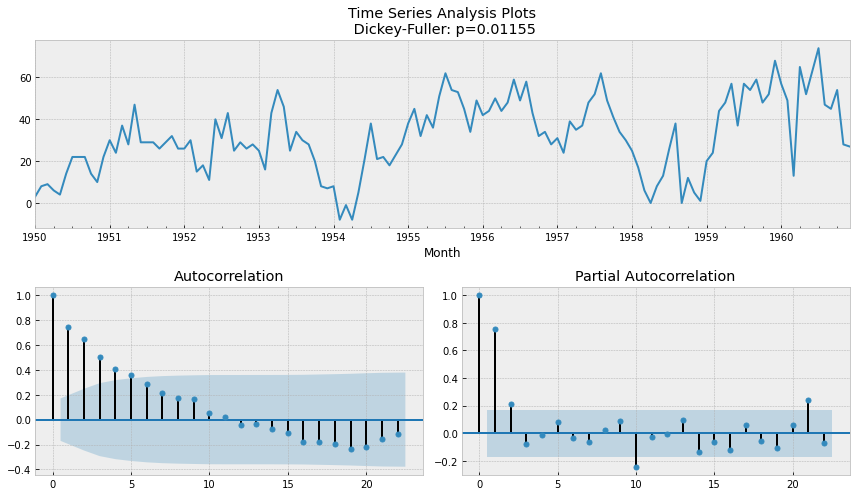

In [10]:
tsplot(data_set['Thousands of Passengers'].diff(12).dropna())

SARIMA MODEL ORDER **(p,d,q)x(P,D,Q,s)**

The order of the (P,D,Q,s) part would be around:
- P = 1-2
- D = 1
- Q = 0
- s = 12 (is is the seasonal order)

So, one viable option could be: **(2,1,1)x(1,1,0,12)**.

To apply the SARIMA we can use the [SARIMAX](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) object from statsmodels:

In [11]:
model = sm.tsa.statespace.SARIMAX(train['train'],order = (2,1,1),seasonal_order = (1,1,0,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               train   No. Observations:                   97
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                -307.865
Date:                             Thu, 02 Feb 2023   AIC                            625.731
Time:                                     11:27:55   BIC                            637.885
Sample:                                 01-01-1949   HQIC                           630.617
                                      - 01-01-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7352      1.154     -0.637      0.524      -2.997       1.527
ar.L2         -0.0488      

### Model diagnostic

We can also check the residual in the model diagnostic:

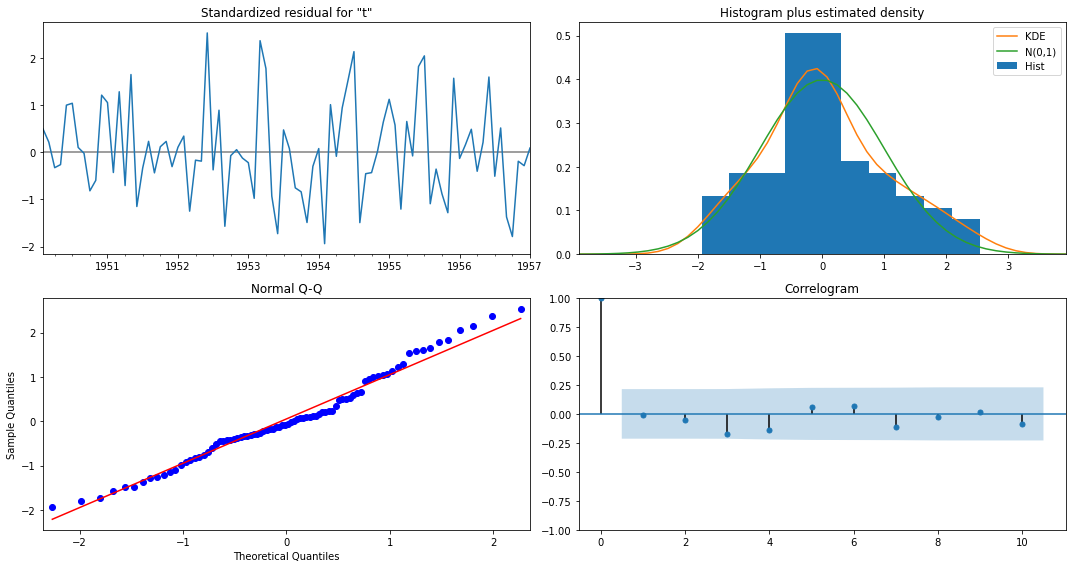

In [12]:
results.plot_diagnostics(figsize=(15,8))
plt.tight_layout()
plt.show()

### Forecasting

Once we passed the model diagnostic phase, we can proceed to make forecast with our model:

In [13]:
test['SARIMA'] = results.predict(start = 97,end = 144,dynamic = False)

In [14]:
evaluate(test['test'], test['SARIMA'])

MAE: 19.699380103638077
MSE: 691.725420785507
RMSE: 26.300673390343203
MAPE: 4.484505307054997


By comparing SARIMA results with Holt-Winters' ones, we can see that SARIMA significantly outperforms it.

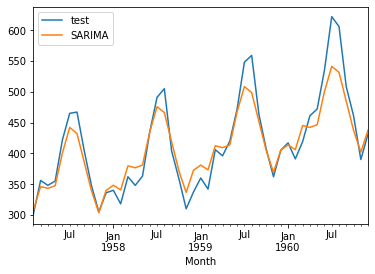

In [15]:
test[['test','SARIMA']].plot()
plt.show()

### Optimize order of SARIMA

If we want to search for the best parameters, we can rely on the auto-arima function even for SARIMA, that automatically iterate over the parameters and select the one that has the best AIC value.

In [16]:
from pmdarima.arima import auto_arima
auto_arima(train['train'], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=626.124, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=628.565, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=622.308, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=622.989, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=624.607, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=624.147, Time=0.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=624.218, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=622.896, Time=0.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=624.620, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=624.204, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=623.797, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=622.415, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=625.731, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [17]:
model = sm.tsa.statespace.SARIMAX(train['train'],order = (1,1,0),seasonal_order = (1,1,0,12))
results = model.fit()
evaluate(test['test'], results.predict(start = 97,end = 143,dynamic = False))

MAE: 19.70138801176502
MSE: 690.9778400473464
RMSE: 26.28645735064629
MAPE: 4.487206967199898


In this case we see that the parameters that optimize the AIC values increase the MSE and the RMSE, but not the MAE and the MAPE errors.